## Example: Artificial Neural Network using Keras

This exercise is adapted from the book Hands-on Data Science for Marketing: Chapter Customer churn and retention.

Dataset is provided by IBM Watson. You can also find it here: https://www.kaggle.com/zagarsuren/telecom-churn-dataset-ibm-watson-analytics. A copy of the data is stored in this week's Data folder.

Note for lecturer: 
* Link to the book via SafariBooksOnline - https://learning.oreilly.com/library/view/hands-on-data-science/9781789346343/b984726e-af92-4525-8a1f-7343a9b2ac76.xhtml
* Sample answer in github: https://github.com/yoonhwang/hands-on-data-science-for-marketing/blob/master/ch.11/python/CustomerRetention.ipynb


**Step 1:** first load the data into a dataframe

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import collections
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.metrics import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.callbacks import Callback
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
df = pd.read_csv('./Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Step 2:** Show the first 10 lines of the contents in df

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [4]:
print('Gender', collections.Counter(df['gender']))

Gender Counter({'Male': 3555, 'Female': 3488})


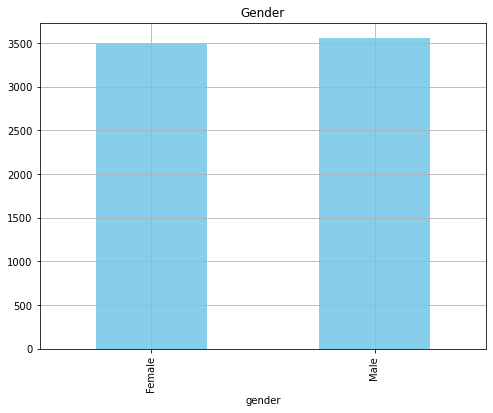

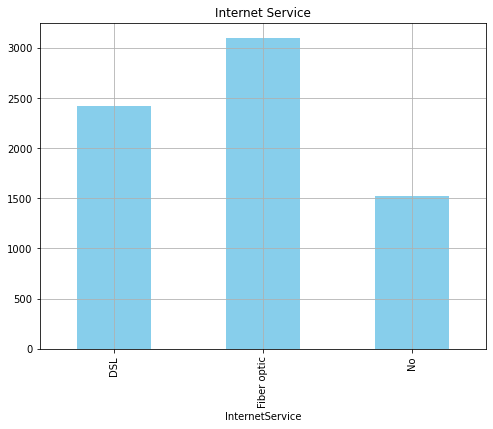

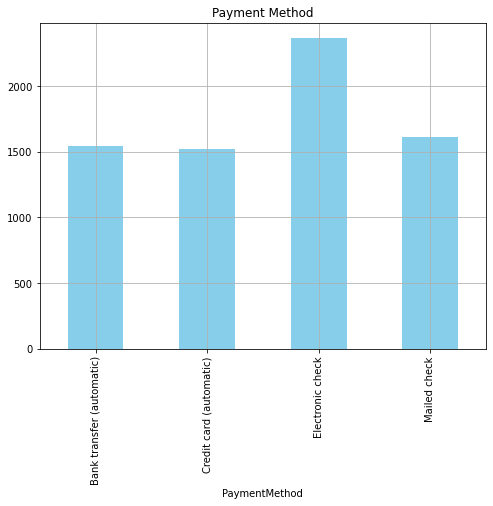

In [5]:
df.groupby('gender').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Gender'
)
plt.show()

df.groupby('InternetService').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Internet Service'
)
plt.show()

df.groupby('PaymentMethod').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Payment Method'
)
plt.show()

**Q:** How many variables/attributes are there in the dataset? which is the target variable?

**Step 3:** Target variable encoding: As you may have noticed from the data, the target variable, Churn, has two values: Yes and No. Please encode these values as 1 for Yes and 0 for No. 

In [6]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

**Q:** What is the overall churn rate? Do you find the churn rate worth paying attention to?

In [7]:
df['Churn'].mean()

0.2653698707936959

**Handling missing values in the TotalCharges column:** If you looked through the TotalCharges column in the dataset, you may have noticed that there are some records with no TotalCharges values. 

Since there are only 11 records with missing TotalCharges values, it is safe to simply ignore and drop those records with missing values.

**Step 4:** Remove entries that have missing TotalCharges values.

In [8]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)

In [9]:
df.shape

(7043, 21)

In [10]:
df.dropna().shape

(7032, 21)

In [11]:
df = df.dropna()

**Transforming continuous variables:** The next step is to scale the continuous variables. 

**Step 5:** Take a look at the summary statistics for continuous variables tenure, MonthlyCharges and TotalCharges


In [12]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


**Step 6:** Normalize the variables tenure, MonthlyCharges and TotalCharges so that it has a mean of 0 and standard deviation of 1 (approximately)

In [13]:
df['MonthlyCharges'] = np.log(df['MonthlyCharges'])
df['MonthlyCharges'] = (df['MonthlyCharges'] - df['MonthlyCharges'].mean())/df['MonthlyCharges'].std()

df['TotalCharges'] = np.log(df['TotalCharges'])
df['TotalCharges'] = (df['TotalCharges'] - df['TotalCharges'].mean())/df['TotalCharges'].std()

df['tenure'] = (df['tenure'] - df['tenure'].mean())/df['tenure'].std()

In [14]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7.032000e+03,7.032000e+03,7.032000e+03
mean,-1.028756e-16,4.688495e-14,7.150708e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.280157e+00,-1.882268e+00,-2.579056e+00
25%,-9.542285e-01,-7.583727e-01,-6.080585e-01
50%,-1.394072e-01,3.885103e-01,1.950521e-01
75%,9.198605e-01,8.004829e-01,8.382338e-01
max,1.612459e+00,1.269576e+00,1.371323e+00


In [15]:
# test with StandardScaler, see if we can get same results
from sklearn.preprocessing import StandardScaler
df2= df.copy()

In [16]:
scaler = StandardScaler()
# print(scaler.fit(data))

In [17]:
# df2['MonthlyCharges'] = np.log(df2['MonthlyCharges'])
# df2['MonthlyCharges'] = scaler.fit_transform(df2['MonthlyCharges'])

# df2['TotalCharges'] = np.log(df2['TotalCharges'])
# df2['TotalCharges'] = scaler.transform(df2['TotalCharges'])

# df2['tenure'] = (df['tenure'] - df['tenure'].mean())/df['tenure'].std()
# df2['tenure'] = scaler.fit_transform(df2['tenure'])


In [18]:

#end test

In [19]:
continuous_vars = list(df.describe().columns)
continuous_vars

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

**One-hot encoding categorical variables:** As you can see from the data, there are many categorical variables. Let's first take a look at the number of unique values each column has. After that, use one-hot encoding technique to turn these columns into values of 0s and 1s. (Tip: read up One-hot encoding online like this: https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/)


**Step 7:** Find out the number of unique values in each column.

In [20]:
for col in list(df.columns):
    print(col, df[col].nunique())

customerID 7032
gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 72
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1584
TotalCharges 6530
Churn 2


**Step 8:** Perform One-hot encoding to all columns except tenure, MonthlyCharges, TotalCharges and Churn as well as those with lower than 5 unique values in respective columns.

In [21]:
dummy_cols = []

sample_set = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].copy(deep=True)

for col in list(df.columns):
    if col not in ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'] and df[col].nunique() < 5:
        dummy_vars = pd.get_dummies(df[col])
        dummy_vars.columns = [col+str(x) for x in dummy_vars.columns]        
        sample_set = pd.concat([sample_set, dummy_vars], axis=1)

**Step 9:** Create features and target_var consisting the correct corresponding column names from sample_set

In [22]:
target_var = 'Churn'
features = [x for x in list(sample_set.columns) if x != target_var]

In [23]:
sample_set

,tenure,MonthlyCharges,TotalCharges,Churn,genderFemale,genderMale,SeniorCitizen0,SeniorCitizen1,PartnerNo,PartnerYes,...,StreamingMoviesYes,ContractMonth-to-month,ContractOne year,ContractTwo year,PaperlessBillingNo,PaperlessBillingYes,PaymentMethodBank transfer (automatic),PaymentMethodCredit card (automatic),PaymentMethodElectronic check,PaymentMethodMailed check
0,-1.280157,-1.054244,-2.281382,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0.064298,0.032896,0.389269,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,-1.239416,-0.061298,-1.452520,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0.512450,-0.467578,0.372439,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,-1.239416,0.396862,-1.234860,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.343113,0.702899,0.422797,0,0,1,1,0,0,1,...,1,0,1,0,0,1,0,0,0,1
7039,1.612459,1.033378,1.265008,0,1,0,1,0,0,1,...,1,0,1,0,0,1,0,1,0,0
7040,-0.872746,-1.068398,-0.702928,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
7041,-1.157934,0.482708,-0.781604,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1


## ANN with Keras
For building ANN models in Python, we are going to use keras package, which is a high-level neural networks library. For more details, we recommend you visit their official documentation at the following link: https://keras.io/. Before we can use this package for building ANN models, we need to install two packages: tensorflow and keras. The keras package uses tensorflow as a backend for building neural network models, so we need to install tensorflow first. You can install these two packages using the following pip commands in your Terminal:

    pip install tensorflow
    pip install keras

if you wish to use conda to install, then use the following command:

    conda install keras 
    
**Step 10:** Build a neural network model with one hidden layer using keras. Import Sequential from keras.model and Dense from keras.layers. Create a model using the Sequential model. Use the following parameters:

* select relu as activation function for the input layer (set output units = 16) 
* select relu as activation function for the hidden layer (set output units = 8)
* select sigmoid as activation function for the ouput layer (set output units = 1)

In [24]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(16, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

**Step 11:** The final step to build a neural network model with the keras package is to compile this model. Use the adam optimizer. Select binary_crossentropy as the loss function, and the accuracy metric to evaluate the model performance during training.

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**Step 12:** Split the dataset to training and testing sample sets. Set 70% for training and 30% for testing.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sample_set[features], 
    sample_set[target_var], 
    test_size=0.3
)

**Step 13:** Train the neural network model using epochs = 50, and batch size of 100

In [27]:
model.fit(X_train, y_train, epochs=50, batch_size=100)

Epoch 1/50
50/50 [==============================] - 1s 2ms/step - loss: 0.5479 - accuracy: 0.7278
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.7292
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.7657
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4366 - accuracy: 0.7850
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.4312 - accuracy: 0.7997
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4244 - accuracy: 0.8035
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4187 - accuracy: 0.8015
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4154 - accuracy: 0.8037
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.4131 - accuracy: 0.8078
Epoch 10/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4117 - accuracy: 0.8072
Epoch 11/50
50/50 [

*Note:* As you can see from this output, loss typically decreases and the accuracy (acc) improves in each epoch. However, the rate of model performance improvement decreases over time. As you can see from this output, there are big improvements in the loss and accuracy measures in the first few epochs and the amount of performance gain decreases over time. You can monitor this process and decide to stop when the amount of performance gain is minimal.

## Model evaluations
Now that we have built our first neural network model, let's evaluate its performance. We are going to look at the overall accuracy, precision, and recall, as well as the receiver operating characteristic (ROC) curve and area under the curve (AUC). First, execute the following code:

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
in_sample_preds = [round(x[0]) for x in model.predict(X_train)]
out_sample_preds = [round(x[0]) for x in model.predict(X_test)]

**Step 14:** Print the following information: Accuracy, precision and recall for the above predictions.

In [29]:
print('In-Sample Accuracy: %0.4f' % accuracy_score(y_train, in_sample_preds))
print('Out-of-Sample Accuracy: %0.4f' % accuracy_score(y_test, out_sample_preds))

print('\n')

print('In-Sample Precision: %0.4f' % precision_score(y_train, in_sample_preds))
print('Out-of-Sample Precision: %0.4f' % precision_score(y_test, out_sample_preds))

print('\n')

print('In-Sample Recall: %0.4f' % recall_score(y_train, in_sample_preds))
print('Out-of-Sample Recall: %0.4f' % recall_score(y_test, out_sample_preds))

In-Sample Accuracy: 0.8167
Out-of-Sample Accuracy: 0.7967


In-Sample Precision: 0.6984
Out-of-Sample Precision: 0.6176


In-Sample Recall: 0.5719
Out-of-Sample Recall: 0.5122


**Step 15:** Compute the AUC numbers

In [30]:
from sklearn.metrics import roc_curve, auc

in_sample_preds = [x[0] for x in model.predict(X_train)]
out_sample_preds = [x[0] for x in model.predict(X_test)]

in_sample_fpr, in_sample_tpr, in_sample_thresholds = roc_curve(y_train, in_sample_preds)
out_sample_fpr, out_sample_tpr, out_sample_thresholds = roc_curve(y_test, out_sample_preds)

in_sample_roc_auc = auc(in_sample_fpr, in_sample_tpr)
out_sample_roc_auc = auc(out_sample_fpr, out_sample_tpr)

print('In-Sample AUC: %0.4f' % in_sample_roc_auc)
print('Out-Sample AUC: %0.4f' % out_sample_roc_auc)

In-Sample AUC: 0.8696
Out-Sample AUC: 0.8383


**Step 16:** visualize this data in the ROC curve

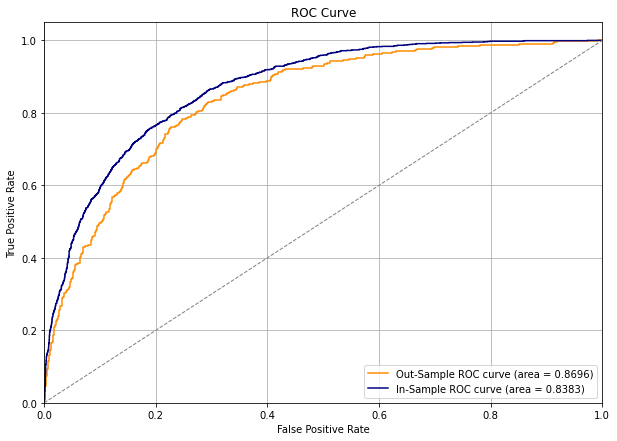

In [31]:
plt.figure(figsize=(10,7))

plt.plot(
    out_sample_fpr, out_sample_tpr, color='darkorange', label='Out-Sample ROC curve (area = %0.4f)' % in_sample_roc_auc
)
plt.plot(
    in_sample_fpr, in_sample_tpr, color='navy', label='In-Sample ROC curve (area = %0.4f)' % out_sample_roc_auc
)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()